In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time

%matplotlib inline

In [3]:
titanic = pd.read_csv('Data/titanic.csv')

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.shape

(891, 12)

In [6]:
titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
# Distribution of Target Variable
titanic['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
# Drop all Categorical Features
cat_feat = list(titanic.select_dtypes(include=['object']).columns) + ['PassengerId']
titanic.drop(cat_feat, axis=1, inplace=True)

In [9]:
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


#### Explore Continuous Features

In [10]:
# General distribution of these features
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
# Correlation Matrix
titanic.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [12]:
# Let's Look at Fare by Different Passenger Class 
titanic.groupby('Pclass')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


In [13]:
def describe_cont_feature(feature):
    print(f'\n*** Results for {feature} ***')
    print(titanic.groupby('Survived')[feature].describe())
    print(ttest(feature))
    
def ttest(feature):
    survived = titanic[titanic['Survived'] == 1][feature]
    not_survived = titanic[titanic['Survived'] == 0][feature]
    tstat, pval = stats.ttest_ind(survived, not_survived, equal_var=False)
    print(f't-statistic: {tstat:.1f}, p-value: {pval:.3}')

In [14]:
# Look at the distribution of each feature at each level of the target variable
for feature in ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']:
    describe_cont_feature(feature)


*** Results for Pclass ***
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  2.531876  0.735805  1.0  2.0  3.0  3.0  3.0
1         342.0  1.950292  0.863321  1.0  1.0  2.0  3.0  3.0
t-statistic: -10.3, p-value: 2.91e-23
None

*** Results for Age ***
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0
t-statistic: nan, p-value: nan
None

*** Results for SibSp ***
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  0.553734  1.288399  0.0  0.0  0.0  1.0  8.0
1         342.0  0.473684  0.708688  0.0  0.0  0.0  1.0  4.0
t-statistic: -1.2, p-value: 0.233
None

*** Results for Parch ***
          count

In [15]:
# Look at the average value of each feature based on whether Age is missing
titanic.groupby(titanic['Age'].isnull()).mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,
False,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


In [16]:
# Read in Data
titanic = pd.read_csv('Data/titanic.csv', usecols=['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


### Plot Continuous Features

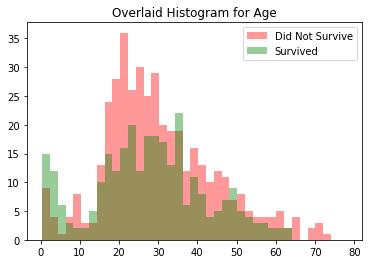

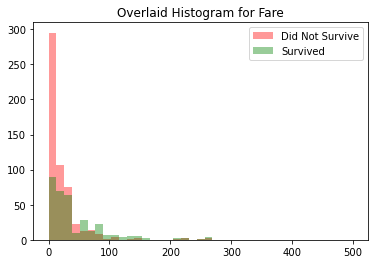

In [17]:
# Plot overlaid histograms for continuous features
for i in ['Age', 'Fare']:
    died = list(titanic[titanic['Survived'] == 0][i].dropna())
    survived = list(titanic[titanic['Survived'] == 1][i].dropna())
    xmin = min(min(died), min(survived))
    xmax = max(max(died), max(survived))
    width = (xmax - xmin) / 40
    sns.distplot(died, color='r', kde=False, bins=np.arange(xmin, xmax, width))
    sns.distplot(survived, color='g', kde=False, bins=np.arange(xmin, xmax, width))
    plt.legend(['Did Not Survive', 'Survived'])
    plt.title(f'Overlaid Histogram for {i}')
    plt.show()

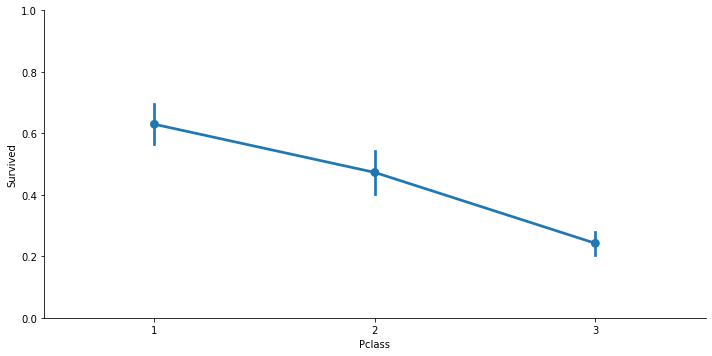

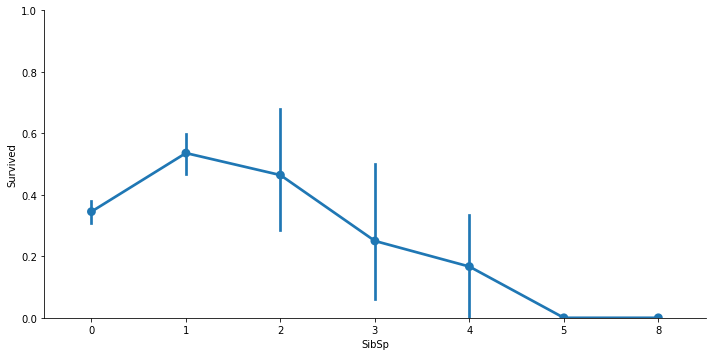

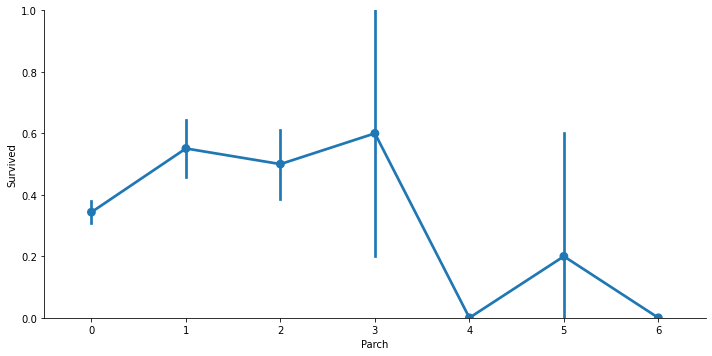

In [18]:
# Generate Categorical Plots for Ordinal Features
for col in ['Pclass', 'SibSp', 'Parch']:
    sns.catplot(x=col, y='Survived', data=titanic, kind='point', aspect=2)
    plt.ylim(0, 1)

(0.0, 1.0)

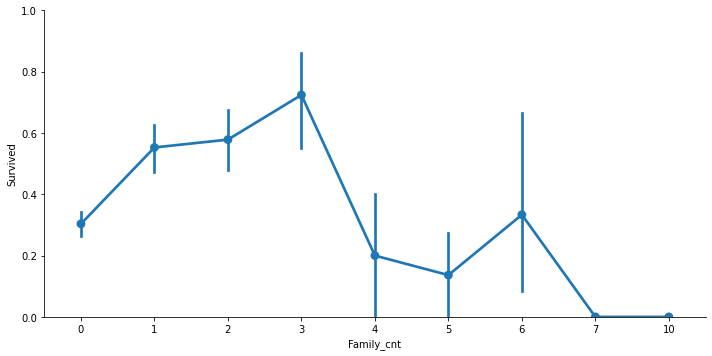

In [19]:
# Create a new family count features
titanic['Family_cnt'] = titanic['SibSp'] + titanic['Parch']
sns.catplot(x='Family_cnt', y='Survived', data=titanic, kind='point', aspect=2)
plt.ylim(0,1)

### Explore Categorical Features

In [20]:
titanic = pd.read_csv('Data/titanic.csv')

In [21]:
# Drop all continuous features
cont_feat = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
titanic.drop(cont_feat, axis=1, inplace=True)
titanic.head()

,Survived,Name,Sex,Ticket,Cabin,Embarked
0,0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,1,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,0,"Allen, Mr. William Henry",male,373450,NaN,S


In [22]:
# Check if there are any missing values
titanic.isnull().sum()

Survived      0
Name          0
Sex           0
Ticket        0
Cabin       687
Embarked      2
dtype: int64

In [23]:
# Explore the number of unique values for each feature
for col in titanic.columns:
    print(f"{col}: {titanic[col].nunique()} unique values.")

Survived: 2 unique values.
Name: 891 unique values.
Sex: 2 unique values.
Ticket: 681 unique values.
Cabin: 147 unique values.
Embarked: 3 unique values.


In [24]:
# Check Survival Rate By Gender
titanic.groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [25]:
# Check Survival Rate By Port Departed From
titanic.groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


In [26]:
# Is Cabin Missing at Random?
titanic.groupby(titanic['Cabin'].isnull()).mean()

,Survived
Cabin,
False,0.666667
True,0.299854


In [27]:
# Look at Unique value for the Ticket Feature
titanic['Ticket'].value_counts()

1601            7
347082          7
CA. 2343        7
347088          6
3101295         6
               ..
F.C.C. 13528    1
28220           1
315153          1
3101298         1
113786          1
Name: Ticket, Length: 681, dtype: int64

In [28]:
# Look at title feature by Parsing Passenger Name
titanic['Title'] = titanic['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip())

In [29]:
# Look at Survival Rate by title
titanic.pivot_table('Survived', index=['Title', 'Sex'], aggfunc=['count', 'mean'])

count      mean
                    Survived  Survived
Title        Sex                      
Capt         male          1  0.000000
Col          male          2  0.500000
Don          male          1  0.000000
Dr           female        1  1.000000
             male          6  0.333333
Jonkheer     male          1  0.000000
Lady         female        1  1.000000
Major        male          2  0.500000
Master       male         40  0.575000
Miss         female      182  0.697802
Mlle         female        2  1.000000
Mme          female        1  1.000000
Mr           male        517  0.156673
Mrs          female      125  0.792000
Ms           female        1  1.000000
Rev          male          6  0.000000
Sir          male          1  1.000000
the Countess female        1  1.000000

### Plot Categorical Features

In [30]:
titanic = pd.read_csv('Data/titanic.csv', usecols=['Survived', 'Name', 'Sex', 'Cabin', 'Embarked'])
titanic.head()

,Survived,Name,Sex,Cabin,Embarked
0,0,"Braund, Mr. Owen Harris",male,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,C85,C
2,1,"Heikkinen, Miss. Laina",female,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,C123,S
4,0,"Allen, Mr. William Henry",male,NaN,S


In [31]:
# Look at title feature by Parsing Passenger Name and Create a Cabin Indicator Variable
titanic['Title_Raw'] = titanic['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
titanic['Title'] = titanic['Title_Raw'].apply(lambda x: x if x in ['Master', 'Mrs', 'Mr', 'Miss'] else 'Other')
titanic['Cabin_ind'] = np.where(titanic['Cabin'].isnull(), 0, 1)
titanic.head()

,Survived,Name,Sex,Cabin,Embarked,Title_Raw,Title,Cabin_ind
0,0,"Braund, Mr. Owen Harris",male,NaN,S,Mr,Mr,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,C85,C,Mrs,Mrs,1
2,1,"Heikkinen, Miss. Laina",female,NaN,S,Miss,Miss,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,C123,S,Mrs,Mrs,1
4,0,"Allen, Mr. William Henry",male,NaN,S,Mr,Mr,0


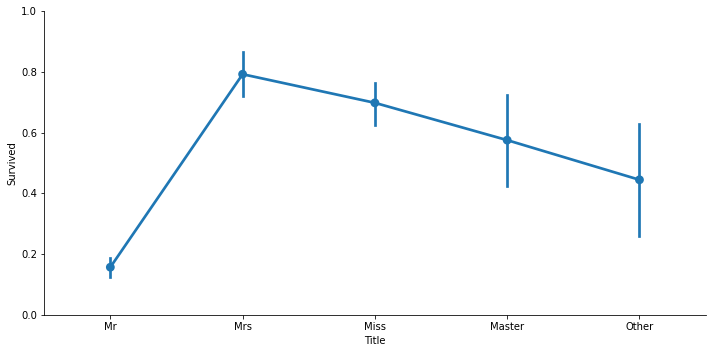

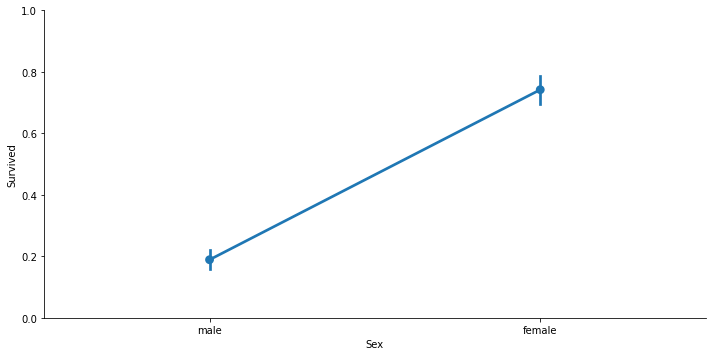

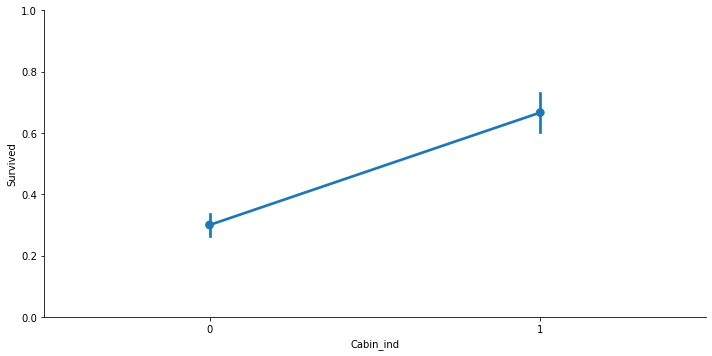

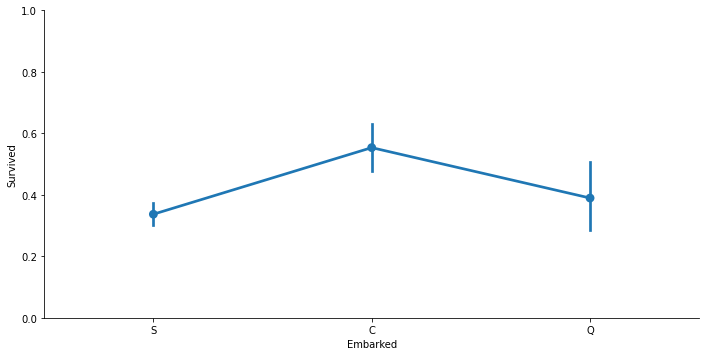

In [32]:
# Generate Categorical Plots for Features
for col in ['Title', 'Sex', 'Cabin_ind', 'Embarked']:
    sns.catplot(x=col, y='Survived', data=titanic, kind='point', aspect=2)
    plt.ylim(0, 1)

In [33]:
# Split Embarked by whether the passenger had a cabin
titanic.pivot_table('Survived', index='Cabin_ind', columns='Embarked', aggfunc='count')

Embarked,C,Q,S
Cabin_ind,,,
0,99,73,515
1,69,4,129


### Treat Missing Values in the Data
Three primary methods to treat missing values:

1. Impute to the median or mean of the feature
2. Model that feature to predict the missing values
3. Assign it some default value(Other or -999)

In [34]:
titanic = pd.read_csv('Data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
# Check where we have missing values
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Fill Missing For `Age`

In [36]:
# Check if Age appears to be missing at random
titanic.groupby(titanic['Age'].isnull()).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Age,,,,,,,
False,448.582633,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
True,435.581921,0.293785,2.598870,NaN,0.564972,0.180791,22.158567


In [37]:
# Fill in missing values for the Age Feature
titanic['Age_clean'] = titanic['Age'].fillna(titanic['Age'].mean())
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Age_clean        0
dtype: int64

In [38]:
# Take a look at the data one more time
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0


### Fill Missing for `Embarked`

In [39]:
# Fill in missing values for the Embarked Feature
titanic['Embarked_clean'] = titanic['Embarked'].fillna('O')
titanic.isnull().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age               177
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             687
Embarked            2
Age_clean           0
Embarked_clean      0
dtype: int64

In [40]:
# Write out data with missing values cleaned up
titanic.to_csv('Data/titanic_no_missing.csv', index=False)

### Creating and Cleaning Features - Cap and Floor Data to Remove Outliers

In [41]:
titanic = pd.read_csv('Data/titanic_no_missing.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S


### Remove Outliers

In [42]:
# See where outliers might be an issue
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_clean
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,29.699118
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,13.002015
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.420000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,22.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,29.699118
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,35.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,80.000000


In [43]:
def detect_outlier(feature):
    outliers = []
    data = titanic[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for y in data:
        z_score = (y-mean)/std
        if np.abs(z_score) > 3:
            outliers.append(y)
    print(f'\nOutlier caps for {feature}')
    print(f'--95p: {data.quantile(.95):.1f} / {len([i for i in data if i > data.quantile(.95)])} values exceed that')
    print(f'--3sd: {mean + 3*(std)} / {len(outliers)} values exceed that')
    print(f'--99p: {data.quantile(.99):.1f} / {len([i for i in data if i > data.quantile(.99)])} values exceed that')

In [44]:
# Determine what the upperbound should be for continuous features

for feat in ['Age_clean', 'SibSp', 'Parch', 'Fare']:
    detect_outlier(feat)


Outlier caps for Age_clean
--95p: 54.0 / 42 values exceed that
--3sd: 68.68326826542585 / 7 values exceed that
--99p: 65.0 / 8 values exceed that

Outlier caps for SibSp
--95p: 3.0 / 30 values exceed that
--3sd: 3.8293811616090405 / 30 values exceed that
--99p: 5.0 / 7 values exceed that

Outlier caps for Parch
--95p: 2.0 / 15 values exceed that
--3sd: 2.7984079986627335 / 15 values exceed that
--99p: 4.0 / 6 values exceed that

Outlier caps for Fare
--95p: 112.1 / 45 values exceed that
--3sd: 181.20081130289694 / 20 values exceed that
--99p: 249.0 / 9 values exceed that


In [45]:
# Cap Features
titanic['Age_clean'].clip(upper=titanic['Age_clean'].quantile(.99), inplace=True)
titanic['Fare_clean'] = titanic['Fare'].clip(upper=titanic['Fare'].quantile(.99))

In [46]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_clean,Fare_clean
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,29.640195,31.224767
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,12.820616,42.524125
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.420000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,22.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,29.699118,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,35.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,65.000000,249.006220


In [47]:
# Write out capped data
titanic.to_csv('Data/titanic_capped.csv', index=False)

### Transform Skewed Features

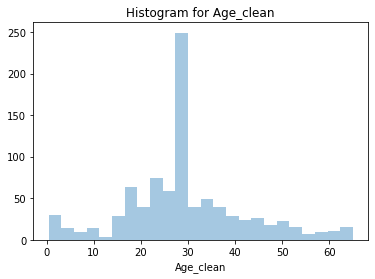

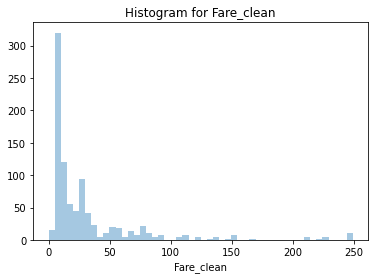

In [48]:
# Plot histogram for each continuous feature to see if the transformation is necessary
for feature in ['Age_clean', 'Fare_clean']:
    sns.distplot(titanic[feature], kde=False)
    plt.title(f'Histogram for {feature}')
    plt.show()

### Box-Cox Transformation

#### Process
1. Determine what range of exponents to test
2. Apply each transformation to each value of chosen feature.
3. Use some criteria to determine which of the transformation yield the best distribution.

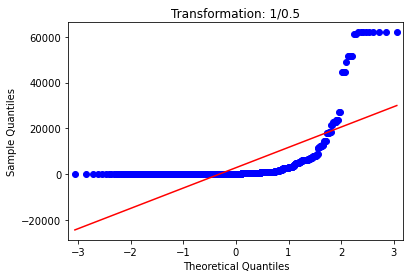

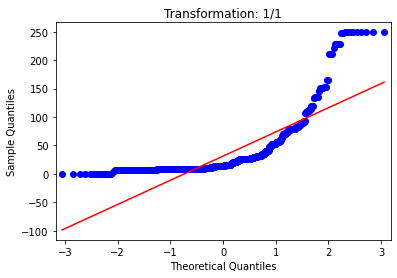

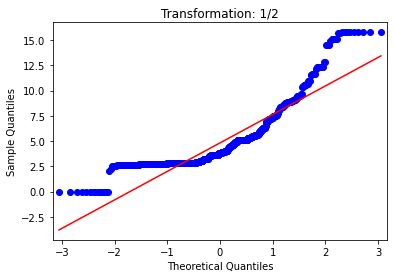

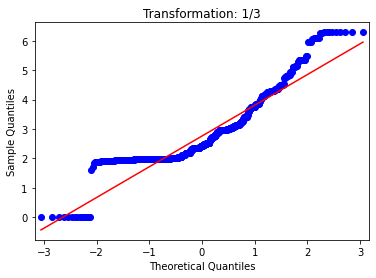

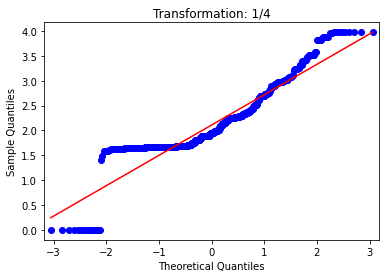

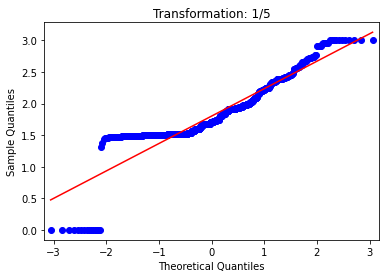

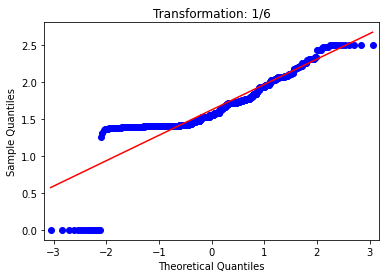

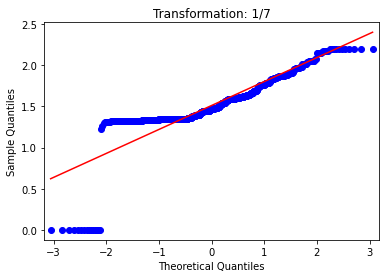

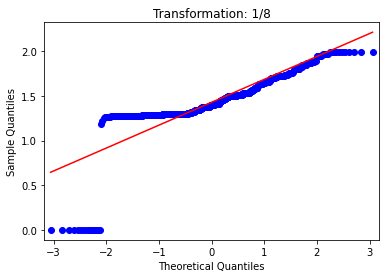

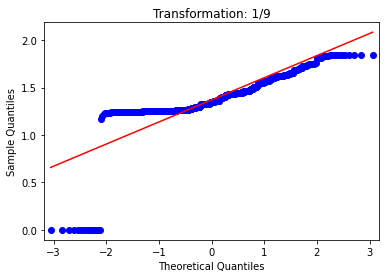

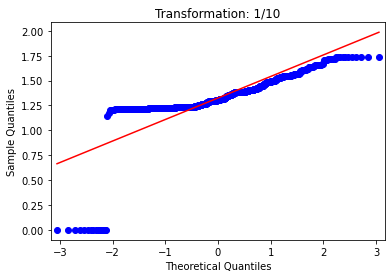

In [49]:
# Generate QQ plots
for i in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    data_t = titanic['Fare_clean']**(1/i)
    qqplot(data_t, line='s')
    plt.title(f'Transformation: 1/{str(i)}')

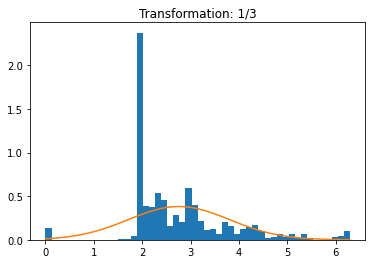

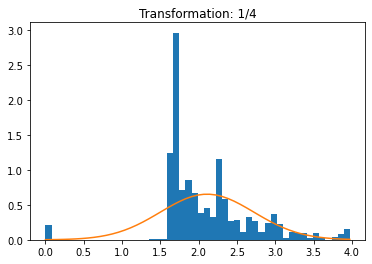

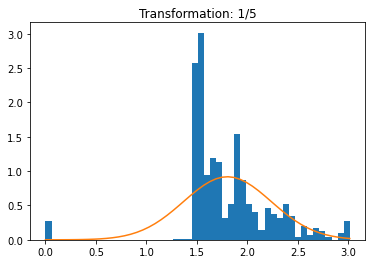

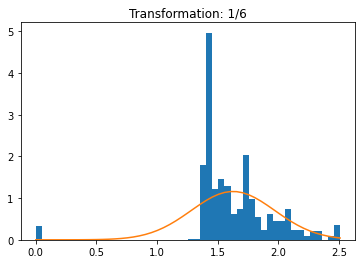

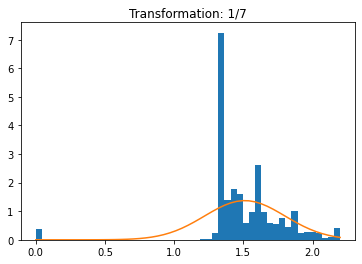

In [50]:
# Box-Cox Transformation
# We want shape of our histogram to approximate the shape of our Normal Curve !
for i in [3,4,5,6,7]:
    data_t = titanic['Fare_clean']**(1/i)
    n, bins, patches = plt.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    plt.plot(bins, stats.norm.pdf(bins, mu, sigma))
    plt.title(f"Transformation: 1/{str(i)}")
    plt.show()

In [51]:
# Create the new transformed feature
titanic['Fare_clean_tr'] = titanic['Fare_clean'].apply(lambda x:x**(1/5))
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S,7.2500,1.486167
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,71.2833,2.347457
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S,7.9250,1.512864
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S,53.1000,2.213191
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S,8.0500,1.517606


In [52]:
titanic.to_csv('Data/titanic_transformed.csv', index=False)

### Create New Features From Text

In [53]:
titanic = pd.read_csv('Data/titanic_transformed.csv')

In [54]:
# Create a title feature by parsing passenger name
titanic['Title'] = titanic['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [55]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S,7.2500,1.486167,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,71.2833,2.347457,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S,7.9250,1.512864,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S,53.1000,2.213191,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S,8.0500,1.517606,Mr


In [56]:
# Look at Survival Rate by Title
titanic.pivot_table('Survived', index=['Title', 'Sex'], aggfunc=['count', 'mean'])

count      mean
                    Survived  Survived
Title        Sex                      
Capt         male          1  0.000000
Col          male          2  0.500000
Don          male          1  0.000000
Dr           female        1  1.000000
             male          6  0.333333
Jonkheer     male          1  0.000000
Lady         female        1  1.000000
Major        male          2  0.500000
Master       male         40  0.575000
Miss         female      182  0.697802
Mlle         female        2  1.000000
Mme          female        1  1.000000
Mr           male        517  0.156673
Mrs          female      125  0.792000
Ms           female        1  1.000000
Rev          male          6  0.000000
Sir          male          1  1.000000
the Countess female        1  1.000000

In [57]:
titanic.to_csv('Data/titanic_title.csv', index=False)

In [58]:
titanic = pd.read_csv('Data/titanic_title.csv')

#### Create Indicator Variable For `Cabin`

In [59]:
# What would an indicator variable for Cabin look like?
titanic.groupby(titanic['Cabin'].isnull())['Survived'].mean()

Cabin
False    0.666667
True     0.299854
Name: Survived, dtype: float64

In [60]:
# Create Indicator Feature
titanic['Cabin_ind'] = np.where(titanic['Cabin'].isnull(), 0, 1)

In [61]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr,Title,Cabin_ind
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S,7.2500,1.486167,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,71.2833,2.347457,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S,7.9250,1.512864,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S,53.1000,2.213191,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S,8.0500,1.517606,Mr,0


In [62]:
titanic.to_csv('Data/titanic_cabin_ind.csv', index=False)

In [63]:
titanic = pd.read_csv('Data/titanic_cabin_ind.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr,Title,Cabin_ind
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S,7.2500,1.486167,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,71.2833,2.347457,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S,7.9250,1.512864,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S,53.1000,2.213191,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S,8.0500,1.517606,Mr,0


### Combine Existing Features Into New Feature

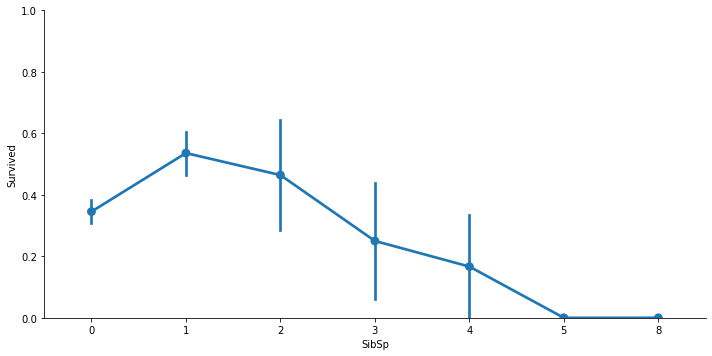

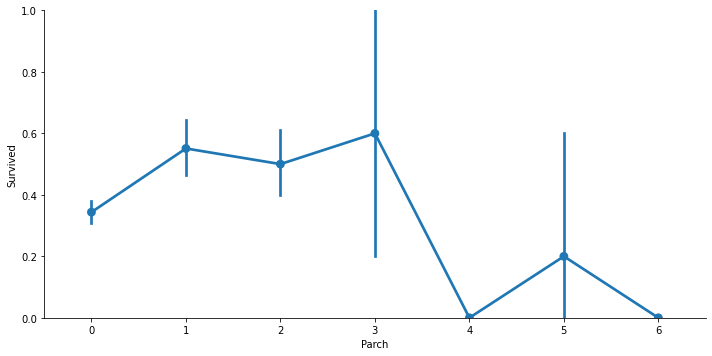

In [64]:
# Combine SibSp & Parch Into New Family_cnt Feature
for col in ['SibSp', 'Parch']:
    sns.catplot(x=col, y='Survived', data=titanic, kind='point', aspect=2)
    plt.ylim(0,1)

(0.0, 1.0)

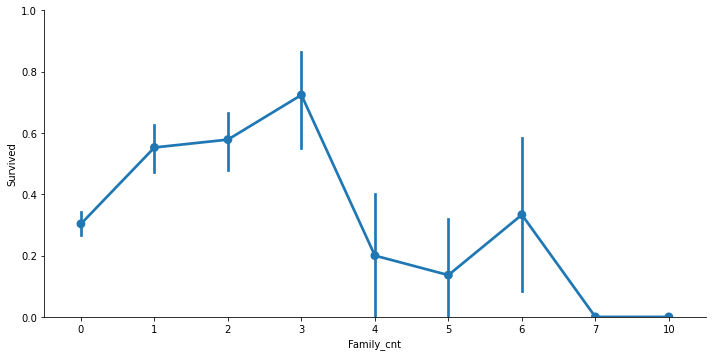

In [65]:
# Create a new family count feature
titanic['Family_cnt'] = titanic['SibSp'] + titanic['Parch']
sns.catplot(x='Family_cnt', y='Survived', data=titanic, kind='point', aspect=2)
plt.ylim(0, 1)

In [66]:
titanic.to_csv('Data/titanic_family_cnt.csv', index=False)

In [67]:
titanic = pd.read_csv('Data/titanic_family_cnt.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr,Title,Cabin_ind,Family_cnt
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S,7.2500,1.486167,Mr,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,71.2833,2.347457,Mrs,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S,7.9250,1.512864,Miss,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S,53.1000,2.213191,Mrs,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S,8.0500,1.517606,Mr,0,0


### Convert Categorical Features to Numeric

In [68]:
for feature in ['Sex', 'Cabin', 'Embarked', 'Embarked_clean', 'Title']:
    le = LabelEncoder()
    titanic[feature] = le.fit_transform(titanic[feature].astype(str))

In [69]:
titanic.to_csv('Data/titanic_numeric.csv', index=False)

In [70]:
titanic = pd.read_csv('Data/titanic_numeric.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr,Title,Cabin_ind,Family_cnt
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,147,2,22.0,3,7.2500,1.486167,11,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,81,0,38.0,0,71.2833,2.347457,12,1,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,147,2,26.0,3,7.9250,1.512864,8,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,55,2,35.0,3,53.1000,2.213191,12,1,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,147,2,35.0,3,8.0500,1.517606,11,0,0


### Split Into Train, Validation and Test Set

In [71]:
# Drop Unnecessary Features and Split Into Training/Test Sets
features = titanic.drop(['PassengerId', 'Ticket', 'Name', 'Survived'], axis=1)
labels = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr,Title,Cabin_ind,Family_cnt
570,2,1,62.0,0,0,10.5000,147,2,62.0,3,10.5000,1.600434,11,0,0
787,3,1,8.0,4,1,29.1250,147,1,8.0,2,29.1250,1.962697,7,0,5
74,3,1,32.0,0,0,56.4958,147,2,32.0,3,56.4958,2.240801,11,0,0
113,3,0,20.0,1,0,9.8250,147,2,20.0,3,9.8250,1.579307,8,0,1
635,2,0,28.0,0,0,13.0000,147,2,28.0,3,13.0000,1.670278,8,0,0


In [72]:
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.6
0.2
0.2


In [73]:
### Write Out All Data
X_train.to_csv('Data/Split_Data/train_features.csv', index=False)
X_val.to_csv('Data/Split_Data/val_features.csv', index=False)
X_test.to_csv('Data/Split_Data/test_features.csv', index=False)

y_train.to_csv('Data/Split_Data/train_labels.csv', index=False)
y_val.to_csv('Data/Split_Data/val_labels.csv', index=False)
y_test.to_csv('Data/Split_Data/test_labels.csv', index=False)

### Standardize All Features

In [74]:
titanic_train = pd.read_csv('Data/Split_Data/train_features.csv')
titanic_val = pd.read_csv('Data/Split_Data/val_features.csv')
titanic_test = pd.read_csv('Data/Split_Data/test_features.csv')

titanic_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr,Title,Cabin_ind,Family_cnt
0,2,1,62.0,0,0,10.5000,147,2,62.0,3,10.5000,1.600434,11,0,0
1,3,1,8.0,4,1,29.1250,147,1,8.0,2,29.1250,1.962697,7,0,5
2,3,1,32.0,0,0,56.4958,147,2,32.0,3,56.4958,2.240801,11,0,0
3,3,0,20.0,1,0,9.8250,147,2,20.0,3,9.8250,1.579307,8,0,1
4,2,0,28.0,0,0,13.0000,147,2,28.0,3,13.0000,1.670278,8,0,0


In [75]:
# Fit the Scaler on the Training Data

scaler = StandardScaler()
scaler.fit(titanic_train)

StandardScaler()

In [76]:
# Scale the training, test and validation sets

features = titanic_train.columns
titanic_train[features] = scaler.transform(titanic_train[features])
titanic_val[features] = scaler.transform(titanic_val[features])
titanic_test[features] = scaler.transform(titanic_test[features])

titanic_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Fare_clean,Fare_clean_tr,Title,Cabin_ind,Family_cnt
0,-0.408652,0.737125,2.258185,-0.464063,-0.468427,-0.412724,0.450064,0.573494,2.570771,0.545364,-0.483840,-0.446199,0.430223,-0.544166,-0.540385
1,0.803682,0.737125,-1.469145,2.692745,0.794906,-0.066661,0.450064,-0.718682,-1.673694,-0.334468,-0.046993,0.373863,-1.784129,-0.544166,2.277639
2,0.803682,0.737125,0.187446,-0.464063,-0.468427,0.441904,0.450064,0.573494,0.212735,0.545364,0.594986,1.003414,0.430223,-0.544166,-0.540385
3,0.803682,-1.356623,-0.640849,0.325139,-0.468427,-0.425266,0.450064,0.573494,-0.730480,0.545364,-0.499672,-0.494025,-1.230541,-0.544166,0.023220
4,-0.408652,-1.356623,-0.088652,-0.464063,-0.468427,-0.366273,0.450064,0.573494,-0.101670,0.545364,-0.425203,-0.288093,-1.230541,-0.544166,-0.540385


In [77]:
titanic_train = pd.read_csv('Data/Split_Data/train_features.csv')
titanic_val = pd.read_csv('Data/Split_Data/val_features.csv')
titanic_test = pd.read_csv('Data/Split_Data/test_features.csv')

In [78]:
# List of features to be used for each dataset
raw_original_features = ['Pclass', 'Sex', 'Age_clean', 'SibSp', 'Parch', 'Fare',
                         'Cabin', 'Embarked']

cleaned_original_features = ['Pclass', 'Sex', 'Age_clean', 'SibSp', 'Parch', 'Fare_clean',
                             'Cabin', 'Embarked_clean']

all_features = ['Pclass', 'Sex', 'Age_clean', 'SibSp', 'Parch', 'Fare_clean', 'Fare_clean_tr',
                'Cabin', 'Cabin_ind', 'Embarked_clean', 'Title', 'Family_cnt']

reduced_features = ['Pclass', 'Sex', 'Age_clean', 'Family_cnt', 'Fare_clean_tr',
                    'Cabin_ind', 'Title']

In [79]:
# Write out final data for each feature set
titanic_train[raw_original_features].to_csv('Data/final_data/train_features_raw.csv', index=False)
titanic_val[raw_original_features].to_csv('Data/final_data/val_features_raw.csv', index=False)
titanic_test[raw_original_features].to_csv('Data/final_data/test_features_raw.csv', index=False)

titanic_train[cleaned_original_features].to_csv('Data/final_data/train_features_original.csv', index=False)
titanic_val[cleaned_original_features].to_csv('Data/final_data/val_features_original.csv', index=False)
titanic_test[cleaned_original_features].to_csv('Data/final_data/test_features_original.csv', index=False)

titanic_train[all_features].to_csv('Data/final_data/train_features_all.csv', index=False)
titanic_val[all_features].to_csv('Data/final_data/val_features_all.csv', index=False)
titanic_test[all_features].to_csv('Data/final_data/test_features_all.csv', index=False)

titanic_train[reduced_features].to_csv('Data/final_data/train_features_reduced.csv', index=False)
titanic_val[reduced_features].to_csv('Data/final_data/val_features_reduced.csv', index=False)
titanic_test[reduced_features].to_csv('Data/final_data/test_features_reduced.csv', index=False)

In [80]:
# Read in all labels
titanic_train_labels = pd.read_csv('Data/split_data/train_labels.csv')
titanic_val_labels = pd.read_csv('Data/split_data/val_labels.csv')
titanic_test_labels = pd.read_csv('Data/split_data/test_labels.csv')

In [81]:
# Write out labels to final directory
titanic_train_labels.to_csv('Data/final_data/train_labels.csv', index=False)
titanic_val_labels.to_csv('Data/final_data/val_labels.csv', index=False)
titanic_test_labels.to_csv('Data/final_data/test_labels.csv', index=False)

### Build a Model with raw Original Features

In [82]:
train_features = pd.read_csv('Data/final_data/train_features_raw.csv')
train_labels = pd.read_csv('Data/final_data/train_labels.csv')

train_features.head()

,Pclass,Sex,Age_clean,SibSp,Parch,Fare,Cabin,Embarked
0,2,1,62.0,0,0,10.5000,147,2
1,3,1,8.0,4,1,29.1250,147,1
2,3,1,32.0,0,0,56.4958,147,2
3,3,0,20.0,1,0,9.8250,147,2
4,2,0,28.0,0,0,13.0000,147,2


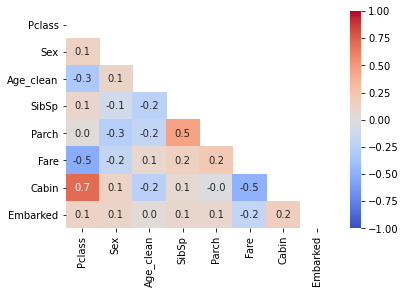

In [83]:
# Generate Correlation Matrix HeatMap
matrix = np.triu(train_features.corr())
sns.heatmap(train_features.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=matrix)

### GridSearchCV

In [84]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}\n')
    
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f"{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}")

In [85]:
# Conduct Search for Best Params while running cross-validation (GridSearchCV)
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [2**i for i in range(3, 10)],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(train_features, train_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 8, 'n_estimators': 512}

0.796 (+/-0.099) for {'max_depth': 2, 'n_estimators': 8}
0.803 (+/-0.096) for {'max_depth': 2, 'n_estimators': 16}
0.785 (+/-0.094) for {'max_depth': 2, 'n_estimators': 32}
0.798 (+/-0.111) for {'max_depth': 2, 'n_estimators': 64}
0.794 (+/-0.105) for {'max_depth': 2, 'n_estimators': 128}
0.79 (+/-0.099) for {'max_depth': 2, 'n_estimators': 256}
0.798 (+/-0.106) for {'max_depth': 2, 'n_estimators': 512}
0.803 (+/-0.086) for {'max_depth': 4, 'n_estimators': 8}
0.803 (+/-0.078) for {'max_depth': 4, 'n_estimators': 16}
0.807 (+/-0.103) for {'max_depth': 4, 'n_estimators': 32}
0.813 (+/-0.115) for {'max_depth': 4, 'n_estimators': 64}
0.826 (+/-0.092) for {'max_depth': 4, 'n_estimators': 128}
0.82 (+/-0.095) for {'max_depth': 4, 'n_estimators': 256}
0.822 (+/-0.103) for {'max_depth': 4, 'n_estimators': 512}
0.811 (+/-0.041) for {'max_depth': 8, 'n_estimators': 8}
0.833 (+/-0.05) for {'max_depth': 8, 'n_estimators': 16}
0.822 (+/-0.056) for

### Feature Importance

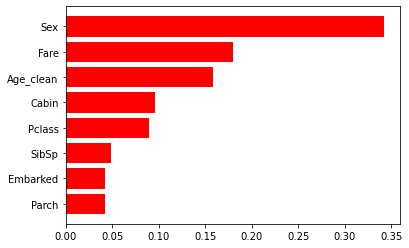

In [86]:
feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [train_features.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [87]:
# Write out the model fit on the whole training set
import joblib
joblib.dump(cv.best_estimator_, 'Models/mdl_raw_original_features.pkl')

['Models/mdl_raw_original_features.pkl']

### Build a Model with Cleaned Original Features

In [88]:
train_features = pd.read_csv('Data/final_data/train_features_original.csv')
train_labels = pd.read_csv('Data/final_data/train_labels.csv')

train_features.head()

,Pclass,Sex,Age_clean,SibSp,Parch,Fare_clean,Cabin,Embarked_clean
0,2,1,62.0,0,0,10.5000,147,3
1,3,1,8.0,4,1,29.1250,147,2
2,3,1,32.0,0,0,56.4958,147,3
3,3,0,20.0,1,0,9.8250,147,3
4,2,0,28.0,0,0,13.0000,147,3


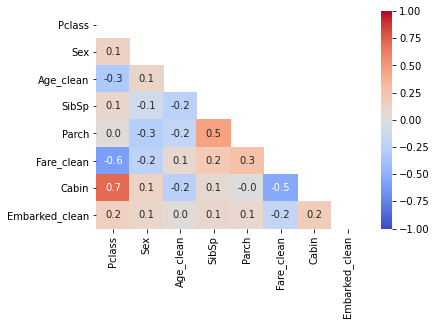

In [89]:
# Generate Correlation Matrix HeatMap
matrix = np.triu(train_features.corr())
sns.heatmap(train_features.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=matrix)

In [90]:
# Conduct Search for Best Params while running cross-validation (GridSearchCV)
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [2**i for i in range(3, 10)],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(train_features, train_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 8, 'n_estimators': 64}

0.792 (+/-0.11) for {'max_depth': 2, 'n_estimators': 8}
0.781 (+/-0.121) for {'max_depth': 2, 'n_estimators': 16}
0.796 (+/-0.094) for {'max_depth': 2, 'n_estimators': 32}
0.787 (+/-0.095) for {'max_depth': 2, 'n_estimators': 64}
0.798 (+/-0.114) for {'max_depth': 2, 'n_estimators': 128}
0.794 (+/-0.109) for {'max_depth': 2, 'n_estimators': 256}
0.792 (+/-0.105) for {'max_depth': 2, 'n_estimators': 512}
0.807 (+/-0.063) for {'max_depth': 4, 'n_estimators': 8}
0.809 (+/-0.096) for {'max_depth': 4, 'n_estimators': 16}
0.826 (+/-0.097) for {'max_depth': 4, 'n_estimators': 32}
0.811 (+/-0.098) for {'max_depth': 4, 'n_estimators': 64}
0.82 (+/-0.105) for {'max_depth': 4, 'n_estimators': 128}
0.817 (+/-0.123) for {'max_depth': 4, 'n_estimators': 256}
0.822 (+/-0.108) for {'max_depth': 4, 'n_estimators': 512}
0.82 (+/-0.064) for {'max_depth': 8, 'n_estimators': 8}
0.832 (+/-0.055) for {'max_depth': 8, 'n_estimators': 16}
0.835 (+/-0.043) for 

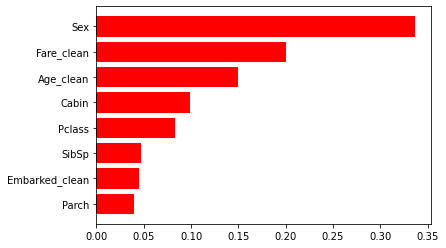

In [91]:
feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [train_features.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [92]:
# Write out the model fit on the whole training set
joblib.dump(cv.best_estimator_, 'Models/mdl_cleaned_original_features.pkl')

['Models/mdl_cleaned_original_features.pkl']

### Build a Model to Compare Features - All Features

In [93]:
train_features = pd.read_csv('Data/final_data/train_features_all.csv')
train_labels = pd.read_csv('Data/final_data/train_labels.csv')

train_features.head()

,Pclass,Sex,Age_clean,SibSp,Parch,Fare_clean,Fare_clean_tr,Cabin,Cabin_ind,Embarked_clean,Title,Family_cnt
0,2,1,62.0,0,0,10.5000,1.600434,147,0,3,11,0
1,3,1,8.0,4,1,29.1250,1.962697,147,0,2,7,5
2,3,1,32.0,0,0,56.4958,2.240801,147,0,3,11,0
3,3,0,20.0,1,0,9.8250,1.579307,147,0,3,8,1
4,2,0,28.0,0,0,13.0000,1.670278,147,0,3,8,0


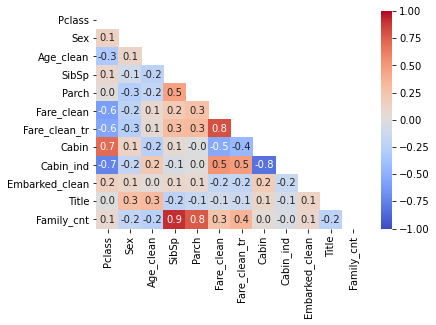

In [94]:
# Generate Correlation Matrix HeatMap
matrix = np.triu(train_features.corr())
sns.heatmap(train_features.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=matrix)

In [95]:
# Conduct Search for Best Params while running cross-validation (GridSearchCV)
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [2**i for i in range(3, 10)],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(train_features, train_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 8, 'n_estimators': 64}

0.788 (+/-0.111) for {'max_depth': 2, 'n_estimators': 8}
0.781 (+/-0.131) for {'max_depth': 2, 'n_estimators': 16}
0.79 (+/-0.135) for {'max_depth': 2, 'n_estimators': 32}
0.779 (+/-0.13) for {'max_depth': 2, 'n_estimators': 64}
0.777 (+/-0.115) for {'max_depth': 2, 'n_estimators': 128}
0.789 (+/-0.109) for {'max_depth': 2, 'n_estimators': 256}
0.779 (+/-0.122) for {'max_depth': 2, 'n_estimators': 512}
0.809 (+/-0.11) for {'max_depth': 4, 'n_estimators': 8}
0.828 (+/-0.073) for {'max_depth': 4, 'n_estimators': 16}
0.815 (+/-0.096) for {'max_depth': 4, 'n_estimators': 32}
0.817 (+/-0.104) for {'max_depth': 4, 'n_estimators': 64}
0.815 (+/-0.094) for {'max_depth': 4, 'n_estimators': 128}
0.826 (+/-0.079) for {'max_depth': 4, 'n_estimators': 256}
0.828 (+/-0.082) for {'max_depth': 4, 'n_estimators': 512}
0.815 (+/-0.051) for {'max_depth': 8, 'n_estimators': 8}
0.82 (+/-0.051) for {'max_depth': 8, 'n_estimators': 16}
0.822 (+/-0.056) for {

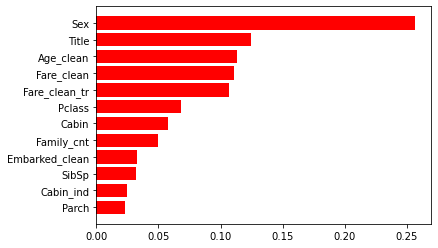

In [96]:
feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [train_features.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [97]:
# Write out the model fit on the whole training set
joblib.dump(cv.best_estimator_, 'Models/mdl_all_features.pkl')

['Models/mdl_all_features.pkl']

### Build a Model to Compare Features - Reduced Set of Features

In [98]:
train_features = pd.read_csv('Data/final_data/train_features_reduced.csv')
train_labels = pd.read_csv('Data/final_data/train_labels.csv')

train_features.head()

,Pclass,Sex,Age_clean,Family_cnt,Fare_clean_tr,Cabin_ind,Title
0,2,1,62.0,0,1.600434,0,11
1,3,1,8.0,5,1.962697,0,7
2,3,1,32.0,0,2.240801,0,11
3,3,0,20.0,1,1.579307,0,8
4,2,0,28.0,0,1.670278,0,8


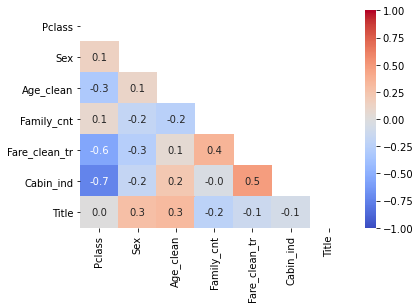

In [99]:
# Generate Correlation Matrix HeatMap
matrix = np.triu(train_features.corr())
sns.heatmap(train_features.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=matrix)

In [100]:
# Conduct Search for Best Params while running cross-validation (GridSearchCV)
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [2**i for i in range(3, 10)],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(train_features, train_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 4, 'n_estimators': 32}

0.809 (+/-0.084) for {'max_depth': 2, 'n_estimators': 8}
0.798 (+/-0.098) for {'max_depth': 2, 'n_estimators': 16}
0.788 (+/-0.109) for {'max_depth': 2, 'n_estimators': 32}
0.785 (+/-0.127) for {'max_depth': 2, 'n_estimators': 64}
0.785 (+/-0.119) for {'max_depth': 2, 'n_estimators': 128}
0.792 (+/-0.123) for {'max_depth': 2, 'n_estimators': 256}
0.79 (+/-0.118) for {'max_depth': 2, 'n_estimators': 512}
0.817 (+/-0.098) for {'max_depth': 4, 'n_estimators': 8}
0.811 (+/-0.106) for {'max_depth': 4, 'n_estimators': 16}
0.822 (+/-0.087) for {'max_depth': 4, 'n_estimators': 32}
0.817 (+/-0.099) for {'max_depth': 4, 'n_estimators': 64}
0.813 (+/-0.105) for {'max_depth': 4, 'n_estimators': 128}
0.813 (+/-0.105) for {'max_depth': 4, 'n_estimators': 256}
0.811 (+/-0.109) for {'max_depth': 4, 'n_estimators': 512}
0.809 (+/-0.034) for {'max_depth': 8, 'n_estimators': 8}
0.809 (+/-0.082) for {'max_depth': 8, 'n_estimators': 16}
0.811 (+/-0.072) fo

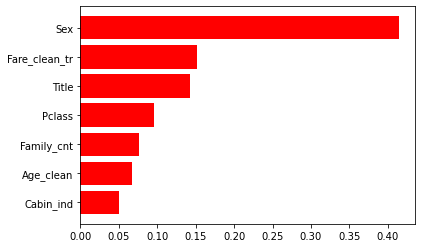

In [101]:
feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [train_features.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [102]:
# Write out the model fit on the whole training set
joblib.dump(cv.best_estimator_, 'Models/mdl_reduced_features.pkl')

['Models/mdl_reduced_features.pkl']

### Compare and Evaluate All Models

In [103]:
val_features_raw = pd.read_csv('Data/final_data/val_features_raw.csv')
val_features_original = pd.read_csv('Data/final_data/val_features_original.csv')
val_features_all = pd.read_csv('Data/final_data/val_features_all.csv')
val_features_reduced = pd.read_csv('Data/final_data/val_features_reduced.csv')

val_labels = pd.read_csv('Data/final_data/val_labels.csv')

In [104]:
val_features_raw.head()

,Pclass,Sex,Age_clean,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,29.699118,1,0,89.1042,86,0
1,1,1,45.500000,0,0,28.5000,56,2
2,3,1,29.699118,0,0,7.7500,147,1
3,2,0,24.000000,1,0,26.0000,147,2
4,2,1,36.000000,0,0,12.8750,90,0


### Read in Models

In [105]:
models = {}

for mdl in ['raw_original', 'cleaned_original', 'all', 'reduced']:
    models[mdl] = joblib.load(f'Models/mdl_{mdl}_features.pkl')

### Evaluate Models on the Validation Set

In [106]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred), 3)
    recall = round(recall_score(labels, pred), 3)
    print(f'{name} -- \tAccuracy: {accuracy} / Precision: {precision} / Recall: {recall} / Latency: {round((end - start)*1000, 1)}ms')

In [107]:
# Evaluate all of our models on the validation set
evaluate_model('Raw Features', models['raw_original'], val_features_raw, val_labels)
evaluate_model('Cleaned Features', models['cleaned_original'], val_features_original, val_labels)
evaluate_model('All Features', models['all'], val_features_all, val_labels)
evaluate_model('Reduced Features', models['reduced'], val_features_reduced, val_labels)

Raw Features -- 	Accuracy: 0.809 / Precision: 0.804 / Recall: 0.631 / Latency: 52.0ms
Cleaned Features -- 	Accuracy: 0.798 / Precision: 0.764 / Recall: 0.646 / Latency: 8.0ms
All Features -- 	Accuracy: 0.82 / Precision: 0.789 / Recall: 0.692 / Latency: 8.0ms
Reduced Features -- 	Accuracy: 0.815 / Precision: 0.796 / Recall: 0.662 / Latency: 5.0ms


### Evaluate Best Model on Test Set

In [108]:
test_features = pd.read_csv('Data/final_data/test_features_all.csv')
test_labels = pd.read_csv('Data/final_data/test_labels.csv')

In [109]:
evaluate_model('All Features', models['all'], test_features, test_labels)

All Features -- 	Accuracy: 0.821 / Precision: 0.855 / Recall: 0.697 / Latency: 9.0ms
